In [2]:
from util import *
import numpy as np
import random, os
import matplotlib.pyplot as plt
import torch

## Setup directories

In [3]:
# input_file
wn_gold_file = "wn_gold_all.tsv"

# ouput_file
wn_gold_10k_amb_file = "wn_gold_10k_amb_head.tsv"
partition_folder = "./head_clustering"
wn_train_10k ="./head_clustering/train.tsv" 
wn_dev_10k ="./head_clustering/dev.tsv" 
wn_test_10k ="./head_clustering/test.tsv" 

## Generate 10K Ambiguous Head Gold Dataset

In [4]:
def distribution(wn_gold_all):
    # obtain the dsitribution of each label
    # output: {label1-> str: num->integer}
    distri = dict()
    for line in wn_gold_all:
        node1_label = line[0]

        node1_id = line[3]

        temp1 = distri.get(node1_label,set())
        temp1.add(node1_id)

        distri[node1_label] = temp1
    
    for item in distri:
        distri[item] = len(distri[item])
    return distri

def ambiguous_filter(lines,ambiguous_num = 1):
    # filter the labels based on their ambiguous number (multiple meanning) global file
    for line in lines:
        subject = line[0]
        
        candits = generate_candidates(subject)
        
        if len(candits)>1: #(multi meaning)
            yield line

def write_gold(filename, lines):
    # write prediction to file
    new_head = ['node1;label','relation','node2;label','node1','node2']
    with open(filename, "w", newline='',encoding="UTF-8") as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(new_head)
        writer.writerows(lines)
        

**write wn_gold_10k file**

In [5]:
# load data
head, lines = load_file(wn_gold_file)
print("total num of lines: ", len(lines))

# check ambiguous of words in each line. Only ambiguous subject word (multiple meanning words) is record.
filtered_lines = list(ambiguous_filter(lines))
print("total num of lines with multi ambiguous subject: ", len(filtered_lines))

# random choice 10000 lines
wn_gold_10k = random.choices(filtered_lines, k=10000)

#write file
write_gold(wn_gold_10k_amb_file, wn_gold_10k)


total num of lines:  111276
total num of lines with multi ambiguous subject:  46651


**Split train, dev, test file**

In [6]:
# define ratio of train, dev, test
train_ratio = 0.8
dev_ratio = 0.1
test_ratio = 1 - train_ratio - dev_ratio

len_gold = len(wn_gold_10k)
train, dev, test = np.split(wn_gold_10k,[int(train_ratio*len_gold),int((train_ratio+dev_ratio)*len_gold)])
print("length of train, dev, test: ", len(train), len(dev), len(test))

# write to file

#generate folder
if not os.path.isdir(partition_folder):
    os.mkdir(partition_folder)

# write train file
write_gold(wn_train_10k, train)

# write dev file
write_gold(wn_dev_10k, dev)

#write test file
write_gold(wn_test_10k, test)

length of train, dev, test:  8000 1000 1000


**Distribution Analysis**

(array([4.979e+03, 7.840e+02, 1.240e+02, 4.000e+01, 1.800e+01, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

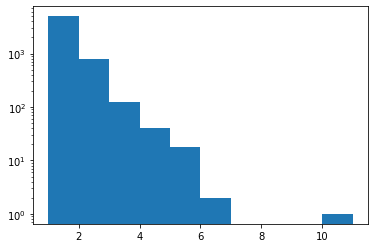

In [7]:
# train data distribution
distri_train = distribution(train)
plt.hist(distri_train.values(),log=True)

(array([924.,   0.,   0.,   0.,   0.,  25.,   0.,   0.,   0.,   2.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

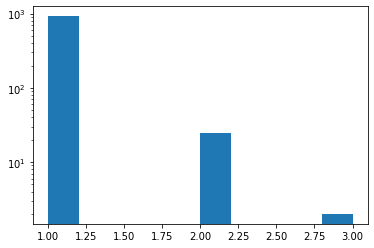

In [8]:
# dev data distribution
distri_dev = distribution(dev)
plt.hist(distri_dev.values(),log=True)

(array([946.,   0.,   0.,   0.,   0.,  16.,   0.,   0.,   0.,   2.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

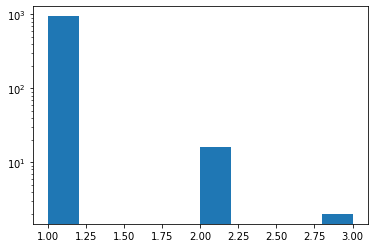

In [9]:
# test data distribution
distri_test = distribution(test)
plt.hist(distri_test.values(),log=True)

## Four baselines to predict (WordNet)
**Random, Frequency, STB model, STR model**

## Random Baseline (WordNet)

In [10]:
def MRS(wn_gold):
    # Random Baseline calculation
    # only predict subject
    wn_predict = []
    for line in wn_gold:
        label1  = line[0]
        label2 = line[2]
        relationship = line[1]
        
        # generate all possible combination of "_"&"-" and check whether it can find sysets.
        # if the combination can generate sysets, use this combinations to generate candidates
        candidates1 = generate_candidates(label1)
        
        if candidates1:
            # random choose candidates
            node1_id = random.choice(candidates1)
        else:
            node1_id = ""
        
        node2_id=""
        
        wn_predict.append([label1, relationship, label2, node1_id, node2_id])
        
    return wn_predict


def validation(wn_predict, wn_gold):
    # valid the accuracy of prediction: only compare the accuracy of subject
    
    correct = 0
    
    for predict, actual in zip(wn_predict, wn_gold):
        predict_label1 = synset2str(predict[3])
        actual_label1 = actual[3]
        
        if predict_label1 == actual_label1:
            # predict and actual is same
            correct += 1
            
    return correct/len(wn_predict)

**train dataset**

In [11]:
wn_ran_train_predict = MRS(train)
accuracy = validation(wn_ran_train_predict, train)
print("Accuracy of train dataset (random baseline): ", accuracy)

Accuracy of train dataset (random baseline):  0.30675


**dev dataset**

In [12]:
wn_ran_dev_predict = MRS(dev)
accuracy = validation(wn_ran_dev_predict, dev)
print("Accuracy of dev dataset (random baseline): ", accuracy)

Accuracy of dev dataset (random baseline):  0.326


**test dataset**

In [13]:
wn_ran_test_predict = MRS(test)
accuracy = validation(wn_ran_test_predict, test)
print("Accuracy of test dataset (random baseline): ", accuracy)

Accuracy of test dataset (random baseline):  0.296


## Frequency Baseline (WordNet)

In [18]:
def MFS(wn_gold):
    # Frequent Baseline Calculation
    wn_predict = []
    for line in wn_gold:
        label1  = line[0]
        label2 = line[2]
        relationship = line[1]
        
        # same as MRS, generate candidates
        candidates1 = generate_candidates(label1)
        
        # obtain the highest frequency
        if candidates1:
            node1_id = candidates1[0]
        else:
            node1_id = ""       

        node2_id = ""
        

        wn_predict.append([label1, relationship, label2, node1_id, node2_id])
        
    return wn_predict

**train dataset**

In [19]:
wn_fre_train_predict = MFS(train)
accuracy = validation(wn_fre_train_predict, train)
print("Accuracy of train dataset (random baseline): ", accuracy)

Accuracy of train dataset (random baseline):  0.355875


**dev dataset**

In [20]:
wn_fre_dev_predict = MFS(dev)
accuracy = validation(wn_fre_dev_predict, dev)
print("Accuracy of dev dataset (random baseline): ", accuracy)

Accuracy of dev dataset (random baseline):  0.368


**test dataset**

In [21]:
wn_fre_test_predict = MFS(test)
accuracy = validation(wn_fre_test_predict, test)
print("Accuracy of test dataset (random baseline): ", accuracy)

Accuracy of test dataset (random baseline):  0.345


## Sentence-Transformer-Bert (STB) (WordNet)

In [15]:
model_STB = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')
word2sentence = {'/r/IsA':"is a", '/r/MadeOf': "is made of",'/r/PartOf':"is part of"}

In [16]:
def sentence_embedding(wn_gold, model, label_embeddings = None, word2sentence = word2sentence):
    # use sentences embedding to find most similar candit
    wn_predict = []
    sents_combine = []
    
    for line in wn_gold:
        sentence = line_sentence(line, word2sentence)
        sents_combine.append(sentence)
    # obtain sentence embedding
    sents_embedding = model.encode(sents_combine)
    
    
    for line,sent_embedding in zip(wn_gold,sents_embedding):
        label1 = line[0]

        #obtain the max similar item for label1
        node_id1 = max_candidate(label1,sent_embedding,label_embeddings) 
        node_id2 = ""
                
        wn_predict.append([label1, line[1], line[2],node_id1,node_id2])
        
    return wn_predict

**train dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(train, model_STB)

# obtain the predict
wn_STB_train_predict= sentence_embedding(train, model_STB,label_embeddings = label_embeddings, word2sentence = word2sentence)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_STB_train_predict, train)
accuracy

**dev dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(dev, model_STB)

# obtain the predict
wn_STB_dev_predict= sentence_embedding(dev, model_STB,label_embeddings = label_embeddings, word2sentence = word2sentence)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_STB_dev_predict, dev)
accuracy

**test dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(test, model_STB)

# obtain the predict
wn_STB_test_predict= sentence_embedding(test, model_STB,label_embeddings = label_embeddings, word2sentence = word2sentence)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_STB_test_predict, test)
accuracy

## Sentence-Transformer-Roberta (STR) (WordNet)

In [14]:
model_STR = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

**train dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(train, model_STR)

# obtain the predict
wn_STR_train_predict= sentence_embedding(train, model_STR,label_embeddings = label_embeddings, word2sentence = word2sentence)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_STR_train_predict, train)
accuracy

**dev dataset**

In [17]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(dev, model_STR)

# obtain the predict
wn_STR_dev_predict= sentence_embedding(dev, model_STR,label_embeddings = label_embeddings, word2sentence = word2sentence)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_STR_dev_predict, dev)
accuracy

0.507

**test dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(test, model_STR)

# obtain the predict
wn_STR_test_predict= sentence_embedding(test, model_STR,label_embeddings = label_embeddings, word2sentence = word2sentence)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_STR_test_predict, test)
accuracy

## POS Baseline

In [ ]:
word2limit = {'/r/IsA':["same"], '/r/MadeOf': ["same"],'/r/PartOf':["same"]}

In [ ]:
def generate_idx_combine(len_nodeid1,len_nodeid2):
    # generate index combination for nodeId combination.
    # nodeId combination will be used to check whther the prediction limitation satisfied
    
    total = len_nodeid1 + len_nodeid2

    for i in range(total):
        for len1 in range(min(i+1,len_nodeid1)):
            len2 = i-len1
            if len2 < len_nodeid2:
                yield len1, len2

In [ ]:
def sentence_embedding_pos(wn_gold, model, label_embeddings = None, word2sentence = word2sentence, word2limit= word2limit):
    # sentence-transformer-bert Calculation
    wn_predict = []
    # frequency place of output data
    freq = []

    sents_combine = []
    for line in wn_gold:
        sentence = line_sentence(line, word2sentence)
        sents_combine.append(sentence)
    sents_embedding = model.encode(sents_combine)

    for line,sent_embedding in zip(wn_gold,sents_embedding):
        label1 = line[0]
        label2 = line[2]
        predicate = line[1]

        #obtain the max similar item for label1
        sort_nodeid1 = sort_candidate(label1,sent_embedding,label_embeddings)
        
        #obtain the max similar item for label2
        sort_nodeid2 = sort_candidate(label2,sent_embedding,label_embeddings)
        
        for idx1, idx2 in generate_idx_combine(len(sort_nodeid1),len(sort_nodeid2)):
            if idx1 == -1:
                node_id1 = ""
                freq1 = -1
            else:
                _, node_id1, freq1 = sort_nodeid1[idx1]

            if idx2 == -1:
                node_id2 = ""
                freq2 = -1
            else:
                _, node_id2, freq2 = sort_nodeid2[idx2]

            status = predicate_limitation_check(node_id1, node_id2, predicate, word2limit)

            if status:
                break
            else:
                continue
            
                
        wn_predict.append([label1, line[1], label2,node_id1,node_id2])
        freq.append(tuple([freq1, freq2]))
    #print(freq)
        
    return wn_predict, freq

**train dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(train, model_STR)

# obtain the predict
wn_POS_train_predict,_= sentence_embedding_pos(train, model_STR,label_embeddings = label_embeddings, word2sentence = word2sentence,word2limit= word2limit)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_POS_train_predict, train)
accuracy

**dev dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(dev, model_STR)

# obtain the predict
wn_POS_dev_predict,_= sentence_embedding_pos(dev, model_STR,label_embeddings = label_embeddings, word2sentence = word2sentence,word2limit= word2limit)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_POS_dev_predict, dev)
accuracy

**test dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(test, model_STR)

# obtain the predict
wn_POS_test_predict,_= sentence_embedding_pos(test, model_STR,label_embeddings = label_embeddings, word2sentence = word2sentence,word2limit= word2limit)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_POS_test_predict, test)
accuracy

# Frquency Distribution Check

In [34]:
def fre_check(wn_predict):
    fre = []
    for line in wn_predict:
        synsets_ = generate_candidates(line[0])
        fre.append(synsets_.index(line[3]))

    plt.hist(fre,log=True,bins=50)

    count =0
    for item in fre:
        if item == 0:
            count += 1

    print("probability of first",count/len(fre))

probability of first 0.317


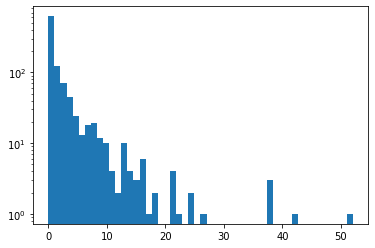

In [35]:
# STR baseline
fre_check(wn_STR_dev_predict)

probability of first 0.309375


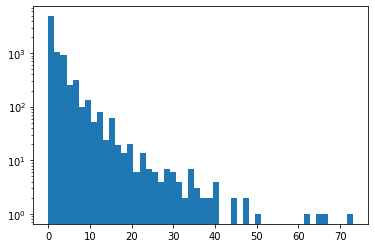

In [36]:
# Random Baseline
fre_check(wn_ran_train_predict)

probability of first 1.0


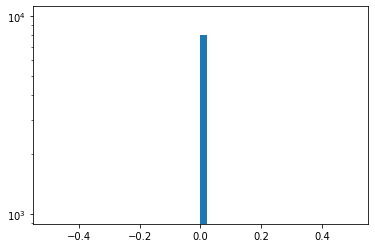

In [38]:
#frequency baseline
fre_check(wn_fre_train_predict)